# Exploratory Data Analysis

### Code Authors:
Eimaan Saqib

Harris Ahmad

In [90]:
import pandas as pd
import numpy as np
from itertools import chain
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.interpolate import interp1d


pd.set_option('display.max_colwidth', None)

In [ ]:
# making the title column as index since it is unique for every row
df = pd.read_csv('dataset.csv')
# resetting the index so it starts from 1
df.index = np.arange(1, len(df) + 1)
# dropping unnamed columns that have nan as their only value
df.drop(['Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'], axis=1, inplace=True)
df.rename(columns={'strong_janguage':'strong_language'}, inplace=True)

## Data Cleaning & Preprocessing

In [ ]:
# dropping all rows with nan values
df = df.dropna(axis=0)

In [ ]:
def col_unique_count(col: pd.Series, ordered=False) -> dict:
    temp = col.to_list()
    temp = [list(t.split(',')) for t in temp]
    temp = list(chain.from_iterable(temp))
    temp = [t.strip() for t in temp]

    count = {}
    for t in temp:
        if t in count:
            count[t] += 1
        else:
            count[t] = 1
    # if sorted flag is true, sort dict by values (descending)
    if ordered:
        count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))
    return count

#### Classifying games according to genres.
Every unique genre would be on the x-axis and the count of each would be on the y-axis.
Notice how every genre is a non-atomic value meaning that it could be divided into multiple genres (simplified).

* some genres are vague to a great degree
* since there are a lot of redundant values, we can select top 10 most popular genres

In [ ]:
# this function returns the unique count of genres in 
genre_count = pd.Series(col_unique_count(df['genres'], True))

In [ ]:
genre_count

In [ ]:
genre_count = genre_count.to_dict()
plt.figure(figsize=(30,70))
y = list(genre_count.keys())
x = list(genre_count.values())
sns.barplot(x=x, y=y, orient='h')
plt.title('Number of video games containing each genre')
plt.show()

How many games do developers on average release and what is their mean rating? Do developers with more games have a higher mean rating?

In [ ]:
developer_count = pd.Series(col_unique_count(df['developers'], True))
developer_count

In [ ]:
user_ratings = {}
for developer in developer_count.keys():
    avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])
    user_ratings[developer] = avg
pd.Series(user_ratings)

In [ ]:
meta_ratings = {}
for developer in developer_count.keys():
    avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])
    meta_ratings[developer] = avg
pd.Series(meta_ratings)

In [ ]:
x = list(developer_count.values())
y1 = list(user_ratings.values())
sns.regplot(x, y1, ci=None)
plt.xlabel("Number of games developed by a developer")
plt.ylabel("Average user score on the games")

In [ ]:
y2 = list(meta_ratings.values())
sns.regplot(x, y2, ci=None)
plt.xlabel("Number of games developed by a developer")
plt.ylabel("Average metacritic score on the games")

How do the popular genres vary over the year?

In [21]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce', format='%Y/%m/%d')

In [22]:
months = df['release_date'].dt.month
months

1       3.0
2       5.0
3       4.0
4       3.0
5       3.0
       ... 
1635    1.0
1638    3.0
1639    8.0
1641    8.0
1642    8.0
Name: release_date, Length: 1400, dtype: float64

In [23]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

In [78]:
popular_genres = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(month_df[month_df['genres'].str.contains(genre)]['metascritic_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    popular_genres[month_map[month]] = {'genres':most_popular, 'Average Metacritic Score':popular_rating}

In [79]:
popular_genres=pd.DataFrame(popular_genres).transpose()
popular_genres['genres'] = popular_genres['genres'].map(lambda x: ', '.join(x))
popular_genres

,genres,Average Metacritic Score
Jan,Linear,93.0
Feb,Sandbox,89.0
Mar,"Western-Style, PC-style RPG",89.0
Apr,Top-Down,85.0
May,GeneralAction,84.5
Jun,Virtual LifeSimulation,83.0
Jul,Stacking,90.0
Aug,"4X, 4XStrategy",85.0
Sep,"PinballAction, Pinball",89.0
Oct,"Management, GovernmentStrategy, Government",87.0


In [65]:
user_popular_genres = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(month_df[month_df['genres'].str.contains(genre)]['users_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    user_popular_genres[month_map[month]] = {'genres':most_popular, 'average user score':popular_rating}

In [66]:
user_popular_genres = pd.DataFrame(user_popular_genres).transpose()
user_popular_genres['genres'] = user_popular_genres['genres'].map(lambda x: ', '.join(x))
user_popular_genres

,genres,average user score
Jan,Linear,8.6
Feb,Sandbox,8.7
Mar,GeneralAction Adventure,8.633333
Apr,Top-Down,8.3
May,GeneralAction Adventure,8.2
Jun,Metroidvania,8.9
Jul,Open-World,8.366667
Aug,Open-WorldAction Adventure,8.3
Sep,"Visual NovelAction, Visual NovelAction Adventure",8.6
Oct,Visual NovelAdventure,8.4


How does this trend in genres vary over the years?

In [80]:
all_years = np.sort(df['release_date'].dt.year.dropna().unique().astype(int))

In [92]:
yearly_popular_genres = {}
for year in all_years:
    year_df = df[df['release_date'].dt.year == year]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(year_df[year_df['genres'].str.contains(genre)]['metascritic_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    yearly_popular_genres[year] = {'genres':most_popular, 'Average Metacritic Score':popular_rating}

In [93]:
yearly_popular_genres = pd.DataFrame(yearly_popular_genres).transpose()
yearly_popular_genres['genres'] = yearly_popular_genres['genres'].map(lambda x: ', '.join(x))
yearly_popular_genres

,genres,Average Metacritic Score
2003,"Action, Shooter, Arcade, First-Person, Sci-Fi, Modern,",72.0
2010,"Action, Action Adventure, Adventure, Open-World, Modern,",79.0
2011,"Action, Action Adventure, Adventure, Open-World, Modern,",78.0
2012,"Action, Platformer, 2D, Puzzle,",75.0
2013,"Action, General, Adventure, Point-and-Click,",80.0
2014,"3D, Sandbox, Fantasy",89.0
2015,"Arcade, First-Person, Role-Playing, Third-Person, ArcadeAction, Western-Style, PC-style RPG",89.0
2016,"Sports, Team, Soccer, SurvivalAction Adventure, SurvivalAction",87.0
2017,"PinballAction, Pinball",89.0
2018,"Visual NovelAction, Visual NovelAction Adventure",85.0


Do metacritic scores and user scores align with each other?

<AxesSubplot:xlabel='metascritic_score', ylabel='users_score'>

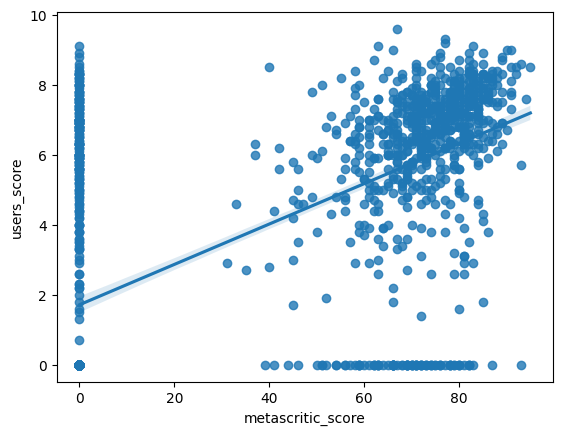

In [94]:
sns.regplot(data=df, x='metascritic_score', y='users_score')

In [101]:
games_with_zero_metascritic_score = df[df['metascritic_score']==0]

In [102]:
games_with_zero_users_score = df[df['users_score']==0]

Which developers consistently get the highest ratings? Is there a trend in popular genres among these high rated developers?

In [98]:
all_developers = list(pd.Series(developer_count.keys()).unique())

In [104]:
developer_ratings = {}
for developer in all_developers:
    avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])
    developer_ratings[developer] = avg
developer_ratings = dict(sorted(developer_ratings.items(), key=lambda item: item[1], reverse=True))

/tmp/ipykernel_13003/1002868910.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])


In [108]:
developer_ratings_series = pd.Series(developer_ratings)
print(developer_ratings_series)

Matt Makes Games Inc.    94.0
SCE Santa Monica         93.0
PLAYDEAD                 91.0
Gearbox Software         91.0
Motion Twin              91.0
                         ... 
The Voices Games          0.0
CUBETYPE                  0.0
Milkstone Studios         0.0
Skandivania Games         0.0
Alan Zucconi              0.0
Length: 1046, dtype: float64


In [109]:
developer_userratings = {}
for developer in all_developers:
    avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])
    developer_userratings[developer] = avg
developer_userratings = dict(sorted(developer_userratings.items(), key=lambda item: item[1], reverse=True))

/tmp/ipykernel_13003/2562103469.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])


In [110]:
developer_userratings_series = pd.Series(developer_userratings)
print(developer_userratings_series)

Gemdrops                       9.6
Sucker Punch                   9.1
Digital Works Entertainment    9.1
Tango Gameworks                8.9
Deck Nine Games                8.1
                              ... 
GameTrust                      0.0
Tequila Works                  0.0
CUBETYPE                       0.0
Skandivania Games              0.0
Alan Zucconi                   0.0
Length: 1046, dtype: float64


In [112]:
meta_top10 = dict(list(developer_ratings.items())[:10])
meta_top10_series = pd.Series(meta_top10)
print(meta_top10_series)

Matt Makes Games Inc.    94.0
SCE Santa Monica         93.0
PLAYDEAD                 91.0
Gearbox Software         91.0
Motion Twin              91.0
Bluepoint Games          91.0
Deck Nine Games          82.0
Jason Roberts            80.0
Black Lab Games          76.0
Slitherine               76.0
dtype: float64


In [113]:
user_top10 = dict(list(developer_userratings.items())[:10])
user_top10_series = pd.Series(user_top10)
print(user_top10_series)

Gemdrops                       9.60
Sucker Punch                   9.10
Digital Works Entertainment    9.10
Tango Gameworks                8.90
Deck Nine Games                8.10
Gears for Breakfast            8.00
Hello There                    7.15
Q Studios                      7.10
Freshly Squeezed               7.00
Jason Roberts                  6.80
dtype: float64


In [116]:
rankings_df = pd.DataFrame({'Ranking':range(1,11),'User Choice':user_top10.keys(), 'User Score':user_top10.values(), 
              'Metacritic Choice':meta_top10.keys(), 'Metacritic Score':meta_top10.values()})
rankings_df

,Ranking,User Choice,User Score,Metacritic Choice,Metacritic Score
0,1,Gemdrops,9.60,Matt Makes Games Inc.,94.0
1,2,Sucker Punch,9.10,SCE Santa Monica,93.0
2,3,Digital Works Entertainment,9.10,PLAYDEAD,91.0
3,4,Tango Gameworks,8.90,Gearbox Software,91.0
4,5,Deck Nine Games,8.10,Motion Twin,91.0
5,6,Gears for Breakfast,8.00,Bluepoint Games,91.0
6,7,Hello There,7.15,Deck Nine Games,82.0
7,8,Q Studios,7.10,Jason Roberts,80.0
8,9,Freshly Squeezed,7.00,Black Lab Games,76.0
9,10,Jason Roberts,6.80,Slitherine,76.0


Do the top 10 user rated developers develop more games with certain genres? How does this trend appear in top 10 metacritic rated developers?

In [131]:
fav_genres = {}
for developer in list(user_top10.keys()):
    dev_df = df[df['developers'].str.contains(developer)]
    genre_counts = col_unique_count(dev_df['genres'], True)
    top_3 = list(genre_counts.keys())[:3]
    fav_genres[developer] = top_3

fav_genres_df = pd.DataFrame(fav_genres).transpose()
fav_genres_df.index.name = 'developer'
fav_genres_df.columns = ['Rank #1', 'Rank #2', 'Rank #3']
fav_genres_df

,Rank #1,Rank #2,Rank #3
developer,,,
Gemdrops,General,Role-Playing,Action RPGRole-Playing
Sucker Punch,General,Action Adventure,Open-World
Digital Works Entertainment,CompilationMiscellaneous,Miscellaneous,Compilation
Tango Gameworks,Action Adventure,SurvivalAction Adventure,Survival
Deck Nine Games,Action Adventure,GeneralAction Adventure,General
Gears for Breakfast,Action,Platformer,3D
Hello There,Rhythm,Action,MusicAction
Q Studios,Role-Playing,Action RPGRole-Playing,Action RPG
Freshly Squeezed,Adventure,3D,Third-Person


In [139]:
fav_genres_meta = {}
for developer in list(meta_top10.keys()):
    dev_df = df[df['developers'].str.contains(developer)]
    genre_counts = col_unique_count(dev_df['genres'], True)
    top_3 = list(genre_counts.keys())[:3]
    fav_genres_meta[developer] = top_3

fav_genres_meta_series = pd.Series(fav_genres_meta)
print(fav_genres_meta_series)

Matt Makes Games Inc.                                [Action, Platformer, 2D]
SCE Santa Monica                                   [Action Adventure, Linear]
PLAYDEAD                                             [Action, Platformer, 2D]
Gearbox Software                              [Action, Shooter, First-Person]
Motion Twin                                    [Platformer, 2DAction, Action]
Bluepoint Games                                   [Action Adventure, General]
Deck Nine Games          [Action Adventure, GeneralAction Adventure, General]
Jason Roberts                                [Puzzle, GeneralPuzzle, General]
Black Lab Games                               [Turn-Based, General, Strategy]
Slitherine                                    [Turn-Based, General, Strategy]
dtype: object


Correlation between different video game features and the ratings produced

In [140]:
df_ratings = df.drop(['title','console','esrb_rating','index','release_date','publishers','developers',
                      'rating','genres'], axis=1)

In [141]:
df_ratings.head(3)

,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,...,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,metascritic_score,users_score
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,61.0,5.5
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,82.0,6.6
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,83.0,8.4


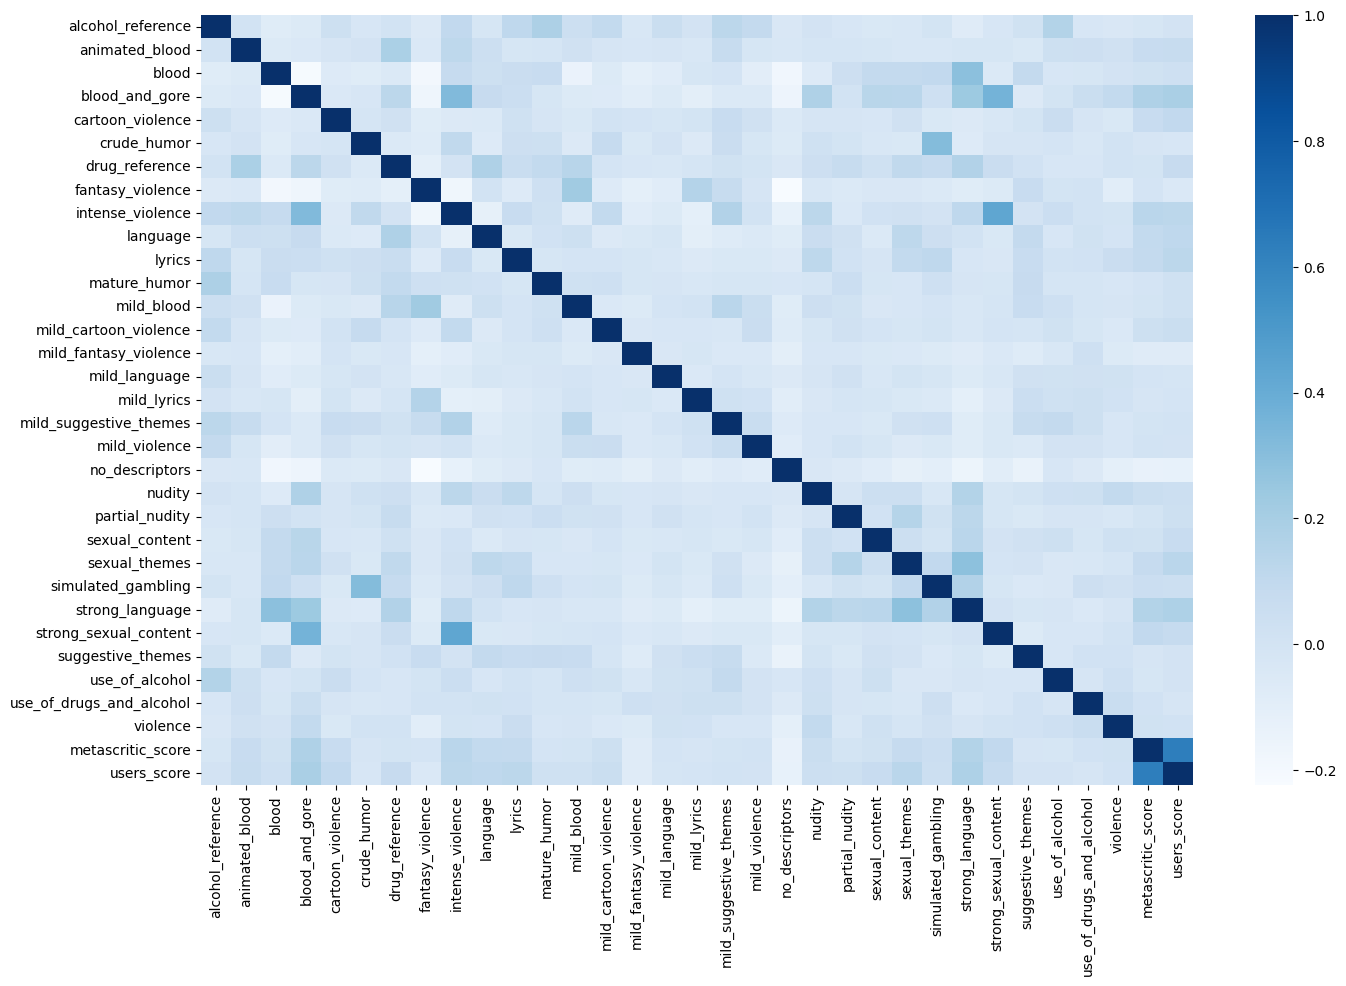

In [142]:
plt.figure(figsize=(16, 10))
corr_heatmap = sns.heatmap(df_ratings.corr(), annot=False, cmap='Blues')
plt.show()

What features have a negative correlation with ratings?

In [143]:
df_ratings.corr()[(df_ratings.corr()['metascritic_score']<0) & (df_ratings.corr()['users_score']<0)][['metascritic_score','users_score']]

,metascritic_score,users_score
crude_humor,-0.017203,-0.024133
fantasy_violence,-0.005004,-0.044614
mild_fantasy_violence,-0.071661,-0.071011
mild_language,-0.008560,-0.010781
mild_lyrics,-0.017607,-0.008654
no_descriptors,-0.128730,-0.125819


Categorizing the total number of movies according to ESRB Rating

In [ ]:
esrb_genres = df[['esrb_rating', 'genres']]
esrb_value_counts = esrb_genres['esrb_rating'].value_counts().to_dict()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_value_counts.values()
labels_index = esrb_value_counts.keys()
ax.bar(labels_index, data_points, color=['cornflowerblue','mediumturquoise', 'skyblue', 'palegreen'])
plt.xlabel('ESRB Rating')
plt.ylabel('Total Games')
plt.show()

In [ ]:
esrb = list(df['esrb_rating'].unique())
esrb_userscore = {}
for rat in esrb:
    avg = np.mean(df[df['esrb_rating'].str.contains(rat)]['users_score'])
    esrb_userscore[rat] = avg
esrb_userscore = dict(sorted(esrb_userscore.items(), key=lambda item: item[1], reverse=True))
esrb_userscore = pd.Series(esrb_userscore).plot(kind='bar')
plt.xlabel('ESRB Rating')
plt.ylabel('Average User Score')

In [ ]:
esrb = list(df['esrb_rating'].unique())
esrb_metacritic = {}
for rat in esrb:
    avg = np.mean(df[df['esrb_rating'].str.contains(rat)]['metascritic_score'])
    esrb_metacritic[rat]=avg
esrb_metacritic = dict(sorted(esrb_metacritic.items(), key=lambda item: item[1], reverse=True))
pd.Series(esrb_metacritic).plot(kind='bar')
plt.xlabel('ESRB Rating')
plt.ylabel('Average Metacritic Score')

In [ ]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
esrb_trend_months = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]['esrb_rating'].value_counts().to_dict()
    esrb_trend_months[month_map[month]] = month_df
'''
We can represent this information for every esrb rating
individually over the months
'''
esrb_T = {}
esrb_ET = {}
esrb_M = {}
esrb_E = {}
for month in esrb_trend_months.items():
    esrb_T[month[0]] = month[1]['T']
    esrb_ET[month[0]] = month[1]['ET']
    esrb_M[month[0]] = month[1]['M']
    esrb_E[month[0]] = month[1]['E']

Trend of E-rated games over the months

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_E.values()
labels_index = esrb_E.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of E-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of E-rated games')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_M.values()
labels_index = esrb_M.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of M-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of M-rated games')
plt.show()

One interesting observation that could be drawn using the above plot is how the number of M-rated games peaked in October. This is when halloween takes place, and the content produced during this time around is also M-rated. Hence, there is an evident trend observed here.

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_ET.values()
labels_index = esrb_ET.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of ET-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of ET-rated games')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_T.values()
labels_index = esrb_T.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of T-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of T-rated games')
plt.show()

Comparing the plots

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels_index = np.array(range(1,13))

X_ = np.linspace(np.min(labels_index), np.max(labels_index), 500)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_E.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_M.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_ET.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_T.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

plt.xticks(np.arange(1, 13, 1.0))
ax.set_xticklabels(list(month_map.values()))
plt.title('Trend of different rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of games')
plt.legend(['E-rated','M-rated','ET-rated','T-rated'])
plt.show()

**Observation:** The production of all games peaked around Feb-Mar and Sep-Oct before going on a decline. M-rated and ET-rated games saw a surge in May before a sudden drop, while the release of E-rated and T-rated games on the other hand remained constant over May-Jun.